# Hyperparameter Tuning to Optimize Model Performance

## Experimenting with Hyperparameter Combinations

In [ ]:
from itertools import product  # For hyperparameter combinations

# Define hyperparameter grid
param_grid = {
    "learning_rate": [0.001, 0.0005, 0.0001],
    "batch_size": [16, 32, 64],
    "optimizer": ["Adam", "SGD"]
}

# Initialize variables to track the best performance
best_hyperparams = None
best_val_accuracy = 0.0

# Loop through all hyperparameter combinations
for learning_rate, batch_size, optimizer_type in product(param_grid["learning_rate"], param_grid["batch_size"], param_grid["optimizer"]):
    print(f"\nTraining with Learning Rate: {learning_rate}, Batch Size: {batch_size}, Optimizer: {optimizer_type}")

    # Update DataLoader with the current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the model and move it to the device
    model = models.densenet121(pretrained=True)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    model = model.to(device)

    # Define the optimizer
    if optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Initialize variables to track performance
    best_val = 0.0  # Best validation accuracy for this combination
    num_epochs = 10  # Use fewer epochs for tuning

    for epoch in range(num_epochs):
        model.train()  # Training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # Validation loop
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = validation_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Save the best model for this combination
        if val_accuracy > best_val:
            best_val = val_accuracy
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_hyperparams = {
                    "learning_rate": learning_rate,
                    "batch_size": batch_size,
                    "optimizer": optimizer_type
                }
                

print(f"\nBest Hyperparameters: {best_hyperparams}")
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


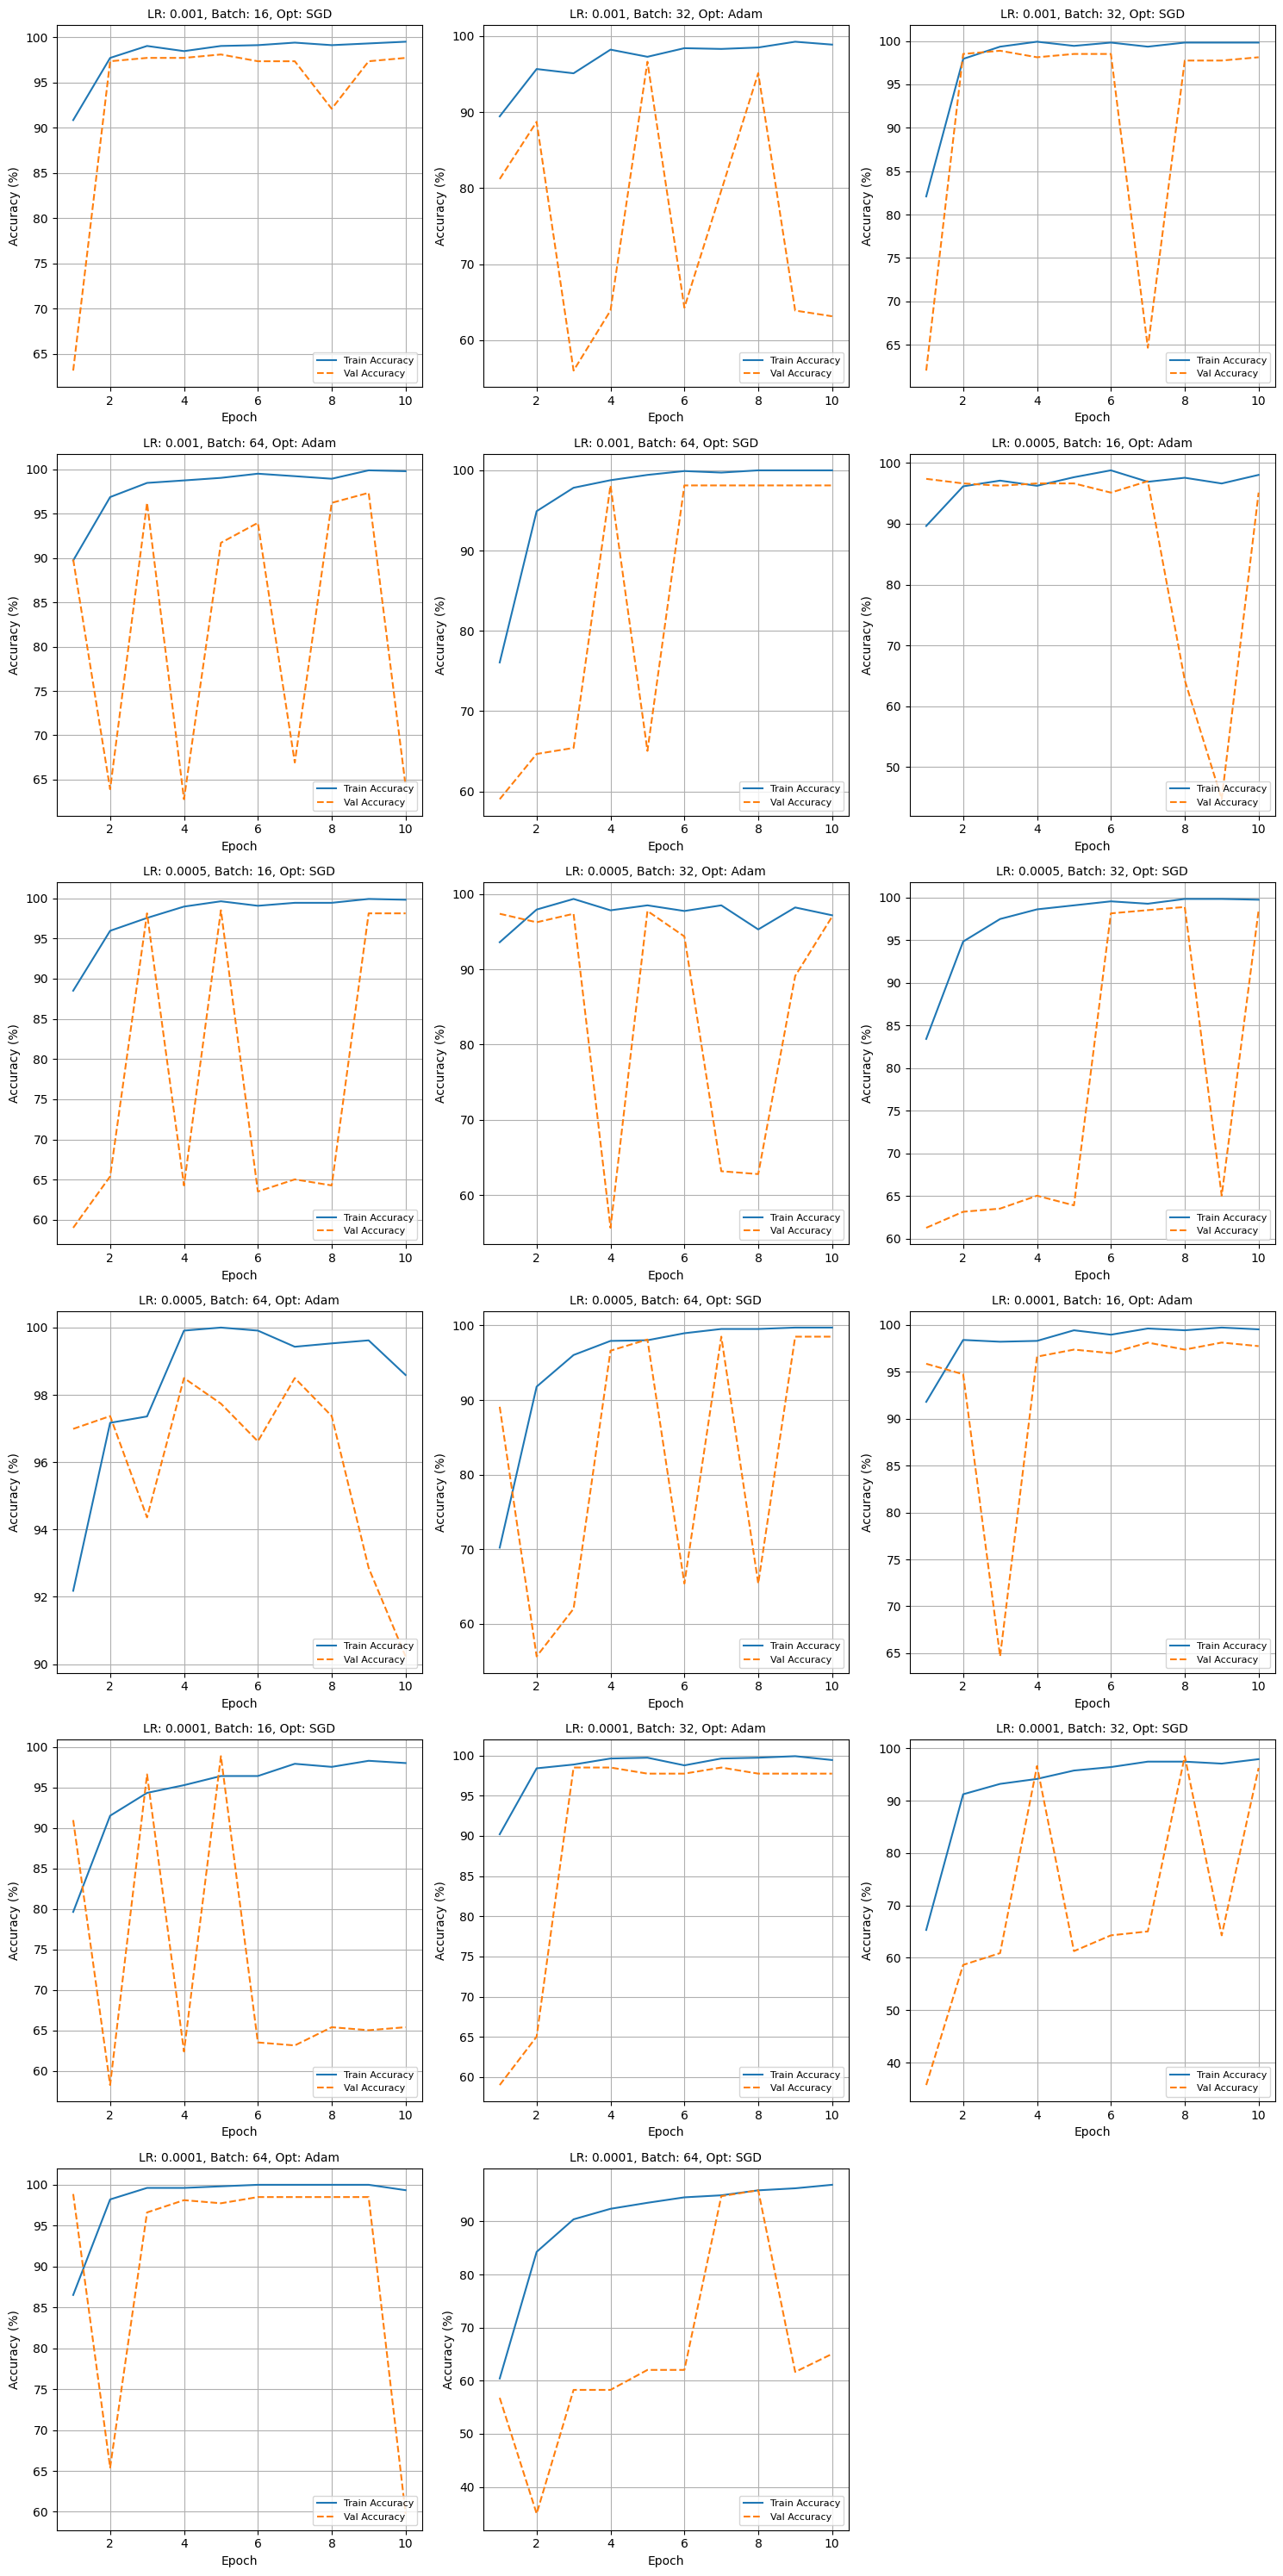

In [1]:
import matplotlib.pyplot as plt
import re
import math

# File path to the Best Hyperparameters.txt file
file_path = "Best Hyperparameters.txt"

# Initialize storage for configurations and their results
results = {}

# Read and parse the file
with open(file_path, 'r') as file:
    lines = file.readlines()
    current_config = None
    
    for line in lines:
        # Match configurations
        config_match = re.match(r"Training with Learning Rate: (.*), Batch Size: (.*), Optimizer: (.*)", line)
        if config_match:
            learning_rate = float(config_match.group(1))
            batch_size = int(config_match.group(2))
            optimizer = config_match.group(3)
            current_config = f"LR: {learning_rate}, Batch: {batch_size}, Opt: {optimizer}"
            results[current_config] = {"epochs": [], "train_acc": [], "val_acc": []}
        
        # Match epoch results
        epoch_match = re.match(r"Epoch (\d+)/\d+, .* Train Accuracy: (.*)%, .* Val Accuracy: (.*)%", line)
        if epoch_match and current_config:
            epoch = int(epoch_match.group(1))
            train_acc = float(epoch_match.group(2))
            val_acc = float(epoch_match.group(3))
            results[current_config]["epochs"].append(epoch)
            results[current_config]["train_acc"].append(train_acc)
            results[current_config]["val_acc"].append(val_acc)

# Plot results for each configuration in a grid of subplots
num_configs = len(results)
cols = 3  # Number of columns in the grid
rows = math.ceil(num_configs / cols)  # Number of rows based on the number of configs

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot each configuration in a separate subplot
for idx, (config, data) in enumerate(results.items()):
    ax = axes[idx]
    ax.plot(data["epochs"], data["train_acc"], label="Train Accuracy")
    ax.plot(data["epochs"], data["val_acc"], label="Val Accuracy", linestyle='--')
    ax.set_title(config, fontsize=10)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.legend(loc="lower right", fontsize=8)
    ax.grid(True)

# Hide any unused subplots
for idx in range(len(results), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


## Refining Model Training with Optimized Learning Rate (0.0001)

In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split


# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Paths to the saved .pt files
train_data_path = "train_data_Intersection.pt"
test_data_path = "test_data_Intersection.pt"
# Load the pre-saved datasets
train_dataset = torch.load(train_data_path)
test_dataset = torch.load(test_data_path)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No shuffling for validation

# Load the pre-trained DenseNet121 model
model = models.densenet121(pretrained=True)

# Modify the classifier for 3 classes
num_classes = 3
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Lists to track training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop with validation
num_epochs = 100  # Set the number of epochs
best_val = 0.0  
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  # Track the loss for this epoch
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in train_loader:
        # Convert 1-channel grayscale images to 3-channel RGB
 
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as model

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * images.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    validation_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    # best_val = 0.0  # Initialize the best validation accuracy
    avg_val_loss = validation_loss / len(val_loader.dataset)
    accuracy = 100 * correct / total
    if accuracy > best_val:
        best_val = accuracy
        torch.save(model.state_dict(), "densenet121_ultrasound_best.pth")

    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Save the final model (optional)
# torch.save(model.state_dict(), "/home/maryam.alshehyari/Documents/training/densenet121_ultrasound.pth")
print(f"Best Validation Accuracy: {best_val:.2f}%")


/tmp/ipykernel_2963359/388125222.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load(train_data_path)
/tmp/ipykernel_2963359/388125222.py:22: Fut

Epoch 1/100, Training Loss: 0.2812, Training Accuracy: 90.39%
Validation Loss: 0.1198, Accuracy: 98.50%
Epoch 2/100, Training Loss: 0.0667, Training Accuracy: 98.11%
Validation Loss: 0.0613, Accuracy: 98.12%
Epoch 3/100, Training Loss: 0.0245, Training Accuracy: 99.81%
Validation Loss: 0.0558, Accuracy: 98.50%
Epoch 4/100, Training Loss: 0.0174, Training Accuracy: 99.91%
Validation Loss: 0.0546, Accuracy: 98.12%
Epoch 5/100, Training Loss: 0.0289, Training Accuracy: 99.15%
Validation Loss: 0.0696, Accuracy: 97.37%
Epoch 6/100, Training Loss: 0.0557, Training Accuracy: 98.49%
Validation Loss: 0.0990, Accuracy: 96.24%
Epoch 7/100, Training Loss: 0.0419, Training Accuracy: 98.77%
Validation Loss: 0.0602, Accuracy: 98.50%
Epoch 8/100, Training Loss: 0.0168, Training Accuracy: 99.43%
Validation Loss: 0.0768, Accuracy: 97.37%
Epoch 9/100, Training Loss: 0.0098, Training Accuracy: 99.81%
Validation Loss: 0.0626, Accuracy: 98.12%
Epoch 10/100, Training Loss: 0.0099, Training Accuracy: 99.91%
V

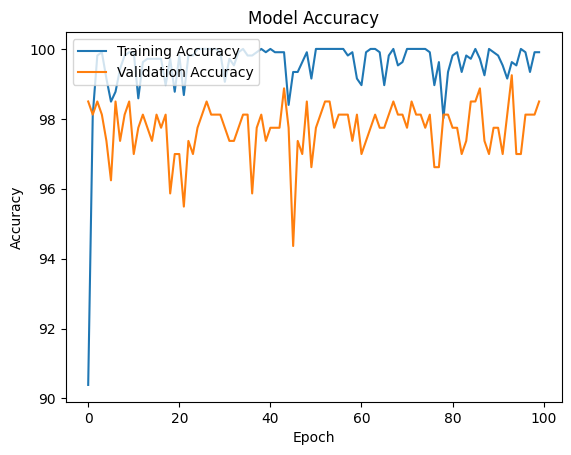

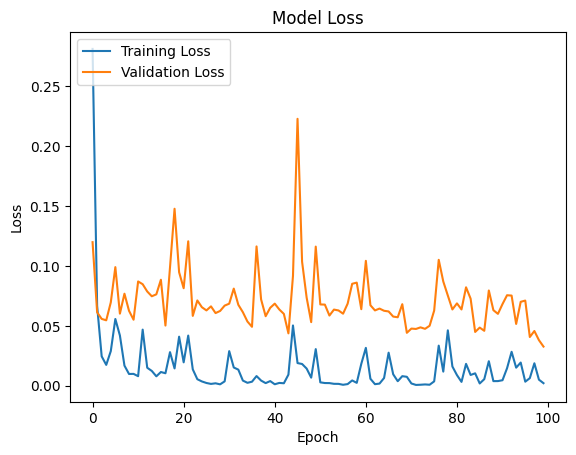

In [2]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
